# Evolution of Fmax and Related Metrics Across Database Versions and K Values

This notebook analyzes the evolution of Fmax and related metrics for the AlignmentScore method across different database versions and K values, using evaluation results from `/home/atoffano/PFP_baselines`. The analysis covers both H30 and D1 datasets, and distinguishes between results using 2024 annotations and those using earlier annotations.

## Import Required Libraries

Import libraries such as `os`, `glob`, `pickle`, `pandas`, `numpy`, `matplotlib`, and `seaborn` for data loading and visualization.

In [1]:
import os
import glob
import pickle
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Define Utility Functions for Loading and Processing Results

Write functions to load `.pkl` results from a given folder, extract Fmax and other relevant metrics, and organize them by database version, method, and dataset (H30 or D1).

In [8]:
def extract_metadata_from_path(path):
    """
    Extracts db_version, dataset (H30/D1), K value, annotation type, and method name from the file path.
    """
    parts = path.split(os.sep)
    # db version like 2020_01 (detection using regex)
    db_version = next((p for p in parts if re.match(r'(\d{4}_\d{2})', p)), None)
    dataset = next((p for p in ['H30', 'D1'] if p in path), None)
    k_value = next((int(p[1:]) for p in parts if p.startswith('k') and p[1:].isdigit()), None)
    annotation_type = '2024_annotations' if '2024_annotations' in path else 'db_annotations'
    # Check if 'AlignmentScore', NaiveBaseline or 'BlastKNN' is in the path and set method_name accordingly
    if 'NaiveBaseline' in path:
        method_name = 'NaiveBaseline'
    elif 'AlignmentScore' in path:
        method_name = 'AlignmentScore'
    elif 'BlastKNN' in path:
        method_name = 'BlastKNN'
    else:
        method_name = 'Unknown'
    return db_version, dataset, k_value, annotation_type, method_name

def load_all_results_to_df(base_dir):
    """
    Recursively finds all eval_beprof_evaluation_results_detailed.pkl files,
    loads them, and returns a DataFrame with metadata and results.
    """
    pattern = os.path.join(base_dir, '**', 'eval_beprof_evaluation_results_detailed.pkl')
    files = glob.glob(pattern, recursive=True)

    records = []
    ontology_map = {
        'bp': 'BPO',
        'mf': 'MFO',
        'cc': 'CCO'
    }
    for file in files:
        db_version, dataset, k_value, annotation_type, method_name = extract_metadata_from_path(file)
        try:
            record = {
                'method': method_name,
                'annotation_type': annotation_type,
                'db_version': db_version,
                'dataset': dataset,
                'k': k_value,
                'method': method_name,
                'file': file
            }
            with open(file, 'rb') as f:
                res = pickle.load(f)
            # Flatten top-level metrics
            for k, v in res.items():
                record[k] = v
            # change in entry 'ontology' value from bp to BPO, mf to MFO, cc to CCO
            if 'ontology' in record:
                record['ontology'] = ontology_map.get(record['ontology'], record['ontology'])
            records.append(record)
        except Exception as e:
            print(f"Failed to load {file}: {e}")
    return pd.DataFrame(records)

def plot_fmax_evolution_by_ontology(df, annotation_type='2024_annotations', method='AlignmentScore', k=None):
    """
    Plot Fmax evolution over db_version with a subplot per ontology (BPO, MFO, CCO).
    """

    ontologies = ['BPO', 'MFO', 'CCO']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for i, ont in enumerate(ontologies):
        ax = axes[i]
        subdf = df[(df['annotation_type'] == annotation_type) & 
                   (df['method'] == method) & 
                   (df['ontology'] == ont)]
        if k is not None:
            subdf = subdf[subdf['k'] == k]
        if subdf.empty:
            ax.set_title(f"{ont} (no data)")
            continue
        for dataset, marker in zip(['H30', 'D1'], ['o', 's']):
            dset = subdf[subdf['dataset'] == dataset].sort_values('db_version')
            if not dset.empty:
                sns.lineplot(data=dset, x='db_version', y='result_fmax', marker=marker, label=dataset, ax=ax)
        ax.set_title(ont)
        ax.set_xlabel('Database Version')
        if i == 0:
            ax.set_ylabel('Fmax')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        for label in ax.get_xticklabels():
            label.set_ha('right')

    plt.suptitle(f'Evolution of Fmax over DB Versions by Ontology ({annotation_type})')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_fmax_evolution_by_dataset_and_k(df, dataset, annotation_type='2024_annotations'):
    """
    Plot Fmax evolution over db_version for a single dataset (H30 or D1),
    with a separate curve for each K value for BlastKNN (different colors),
    and AlignmentScore as a single curve (shown as k=max).
    """
    ontologies = ['BPO', 'MFO', 'CCO']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for i, ont in enumerate(ontologies):
        ax = axes[i]
        # BlastKNN curves by k
        subdf_blast = df[
            (df['annotation_type'] == annotation_type) &
            (df['dataset'] == dataset) &
            (df['ontology'] == ont) &
            (df['method'] == 'BlastKNN')
        ]
        k_values = sorted(subdf_blast['k'].dropna().unique())
        for idx, k in enumerate(k_values):
            kdf = subdf_blast[subdf_blast['k'] == k].sort_values('db_version')
            if not kdf.empty:
                sns.lineplot(data=kdf, x='db_version', y='result_fmax', marker='o', label=f'BlastKNN k={int(k)}', ax=ax)
        # AlignmentScore as k=max
        subdf_align = df[
            (df['annotation_type'] == annotation_type) &
            (df['dataset'] == dataset) &
            (df['ontology'] == ont) &
            (df['method'] == 'AlignmentScore')
        ].sort_values('db_version')
        if not subdf_align.empty:
            sns.lineplot(data=subdf_align, x='db_version', y='result_fmax', marker='o', label='AlignmentScore (k=max)', ax=ax)
        if subdf_blast.empty and subdf_align.empty:
            ax.set_title(f"{ont} (no data)")
            continue
            
        ax.set_title(ont)
        ax.set_xlabel('Database Version')
        ax.set_ylabel('Fmax')
        ax.legend(title='Method/K')
        ax.tick_params(axis='x', rotation=45)
        for label in ax.get_xticklabels():
            label.set_ha('right')

    plt.suptitle(f'Fmax Evolution over DB Versions for {dataset} ({annotation_type}, BlastKNN by K, AlignmentScore)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [5]:
df_results = load_all_results_to_df('/home/atoffano/PFP_baselines')
df_results

method   annotation_type db_version dataset     k  \
0     AlignmentScore    db_annotations    2010_01     H30   NaN   
1      NaiveBaseline    db_annotations    2010_01     H30   NaN   
2           BlastKNN    db_annotations    2010_01     H30   1.0   
3           BlastKNN    db_annotations    2010_01     H30   3.0   
4           BlastKNN    db_annotations    2010_01     H30   5.0   
...              ...               ...        ...     ...   ...   
2011        BlastKNN  2024_annotations    2003_12     H30   3.0   
2012        BlastKNN  2024_annotations    2003_12     H30   5.0   
2013        BlastKNN  2024_annotations    2003_12     H30  10.0   
2014        BlastKNN  2024_annotations    2003_12     H30  15.0   
2015        BlastKNN  2024_annotations    2003_12     H30  20.0   

                                                   file ontology  \
0     /home/atoffano/PFP_baselines/2010_01/baselines...      BPO   
1     /home/atoffano/PFP_baselines/2010_01/baselines...      BPO   
2     /home/atoffano/PFP_baselines/2010_01/baselines...      BPO   
3     /home/atoffano/PFP_baselines/2010_01/baselines...      BPO   
4     /home/atoffano/PFP_baselines/2010_01/baselines...      BPO   
...                                                 ...      ...   
2011  /home/atoffano/PFP_baselines/2003_12/baselines...      MFO   
2012  /home/atoffano/PFP_baselines/2003_12/baselines...      MFO   
2013  /home/atoffano/PFP_baselines/2003_12/baselines...      MFO   
2014  /home/atoffano/PFP_baselines/2003_12/baselines...      MFO   
2015  /home/atoffano/PFP_baselines/2003_12/baselines...      MFO   

                                                recalls  \
0     [0.0, 0.4086265245766506, 0.42150474615572997,...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.5026615868793943, 0.5026615868793943, ...   
3     [0.0, 0.455730196703168, 0.455730196703168, 0....   
4     [0.0, 0.44221154684126196, 0.44221154684126196...   
...                                                 ...   
2011  [0.7946706977460686, 0.7946706977460686, 0.794...   
2012  [0.7765199554689499, 0.7765199554689499, 0.776...   
2013  [0.7451620428994952, 0.7549552889884952, 0.755...   
2014  [0.7376168459882892, 0.745672608392385, 0.7458...   
2015  [0.7181676402056923, 0.7385859555019203, 0.738...   

                                             precisions  \
0     [1.0, 0.7478764200757829, 0.7489124059845348, ...   
1     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [1.0, 0.6637961111863996, 0.6637961111863996, ...   
3     [1.0, 0.7278523074512685, 0.7278523074512685, ...   
4     [1.0, 0.7354786839974897, 0.7354786839974897, ...   
...                                                 ...   
2011  [0.8454022890486262, 0.8454022890486262, 0.845...   
2012  [0.8613499939099419, 0.8613499939099419, 0.861...   
2013  [0.8783441700989848, 0.8780829755762369, 0.878...   
2014  [0.8819258177314635, 0.8818124628508345, 0.881...   
2015  [0.8815728903334353, 0.882726425395567, 0.8827...   

                                           icprecisions  ... result_aupr  \
0     [0.7246002494635212, 0.7256924440264374, 0.725...  ...    0.590056   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...    0.151150   
2     [0.6272844920586644, 0.6272844920586644, 0.627...  ...    0.583229   
3     [0.7011287578242176, 0.7011287578242176, 0.701...  ...    0.595052   
4     [0.7092042229082786, 0.7092042229082786, 0.709...  ...    0.593028   
...                                                 ...  ...         ...   
2011  [0.828563834739446, 0.828563834739446, 0.82856...  ...    0.061323   
2012  [0.847847797612598, 0.847847797612598, 0.84784...  ...    0.083666   
2013  [0.8675234510428902, 0.8674748884649377, 0.867...  ...    0.116688   
2014  [0.8713024690683165, 0.8713344371099567, 0.871...  ...    0.124722   
2015  [0.8718051398915575, 0.8729689488349404, 0.872...  ...    0.142530   

     result_icaupr result_dpaupr  \
0         0.122650      0

## Plot Evolution of Fmax Over Database Versions (db_annotations)

For folders under `db_annotations`, plot Fmax as a function of db version, with separate curves for H30 and D1. Use matplotlib or seaborn for line plots.

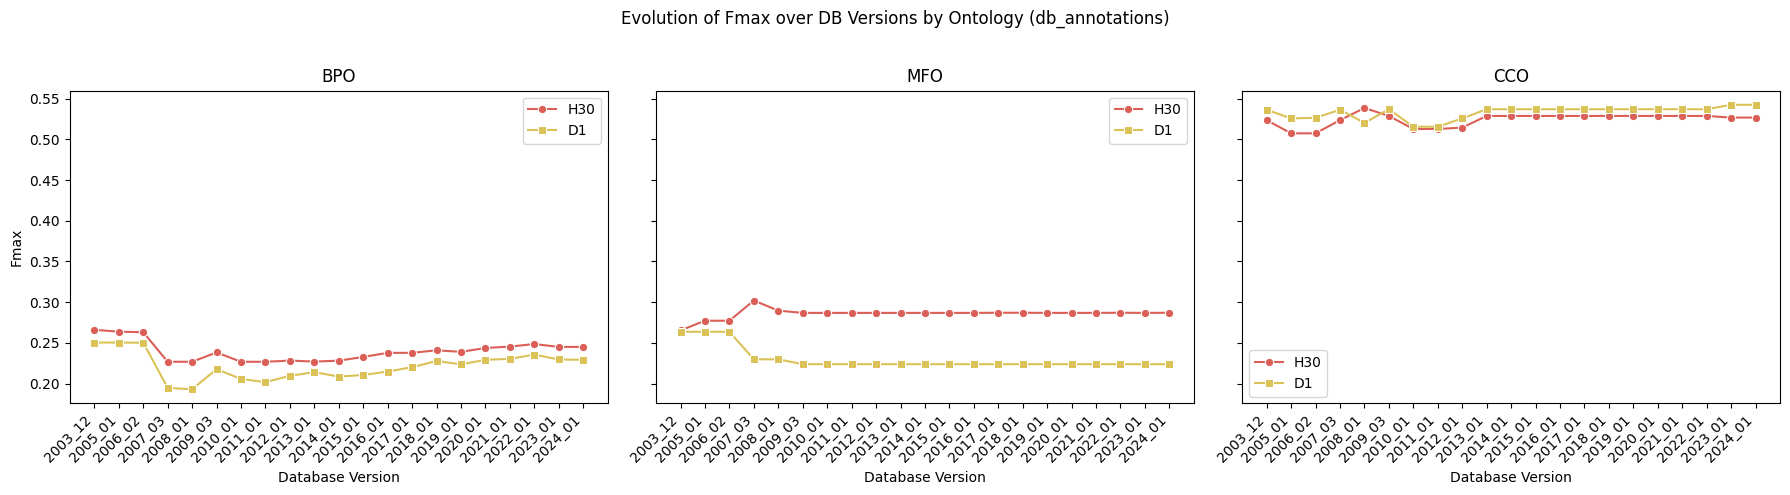

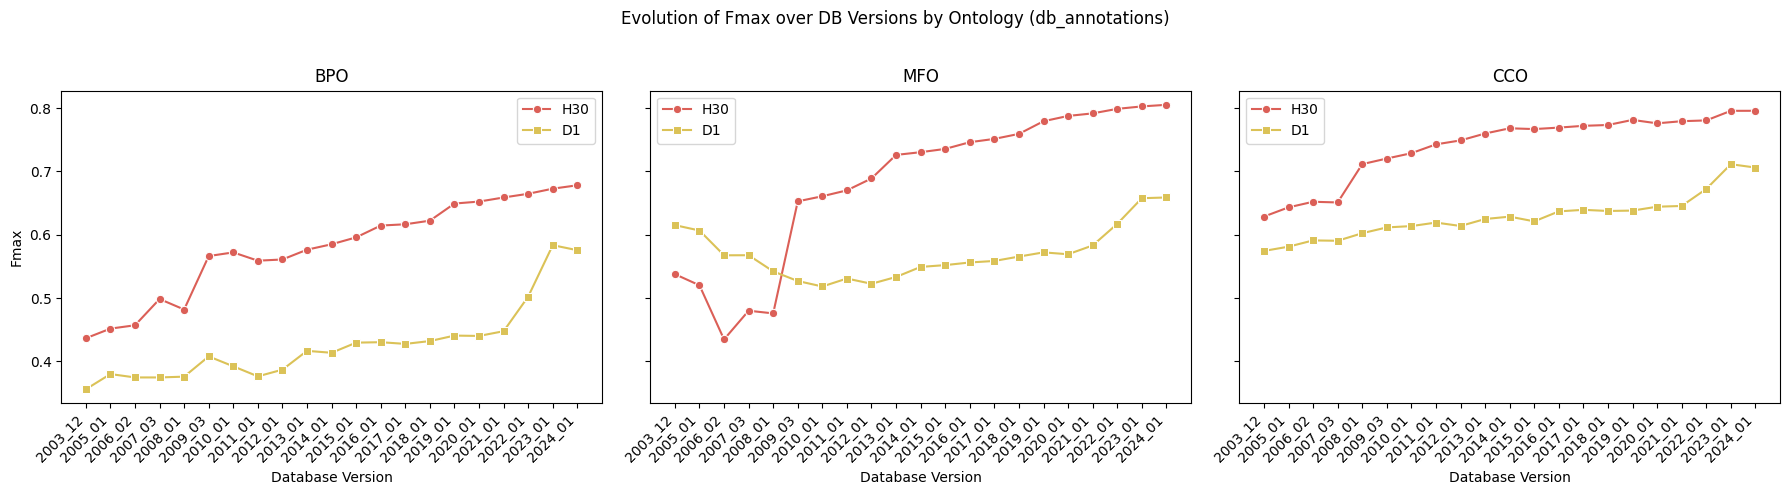

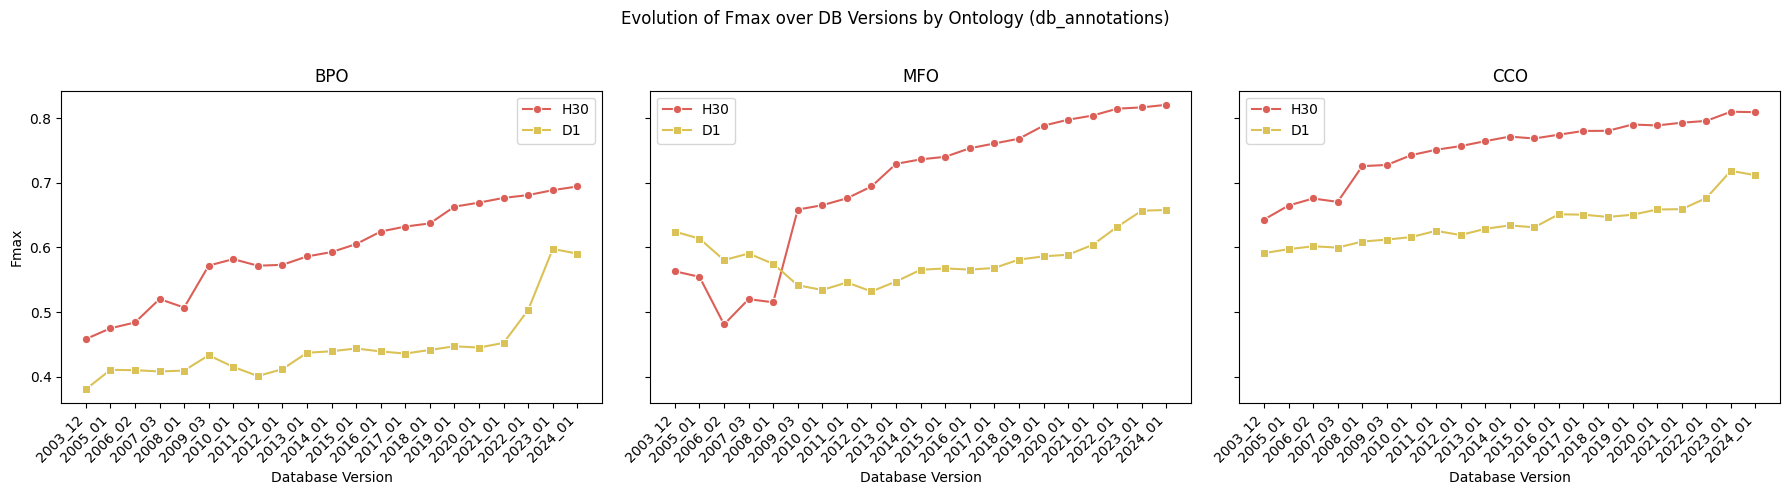

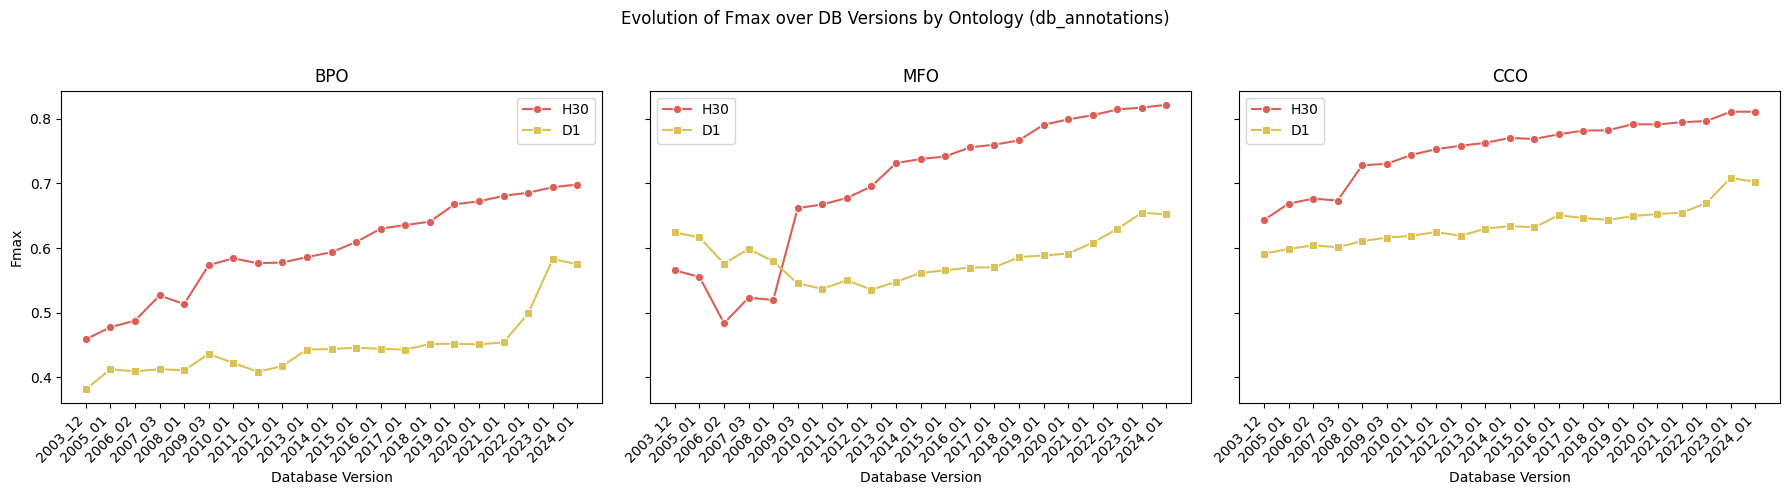

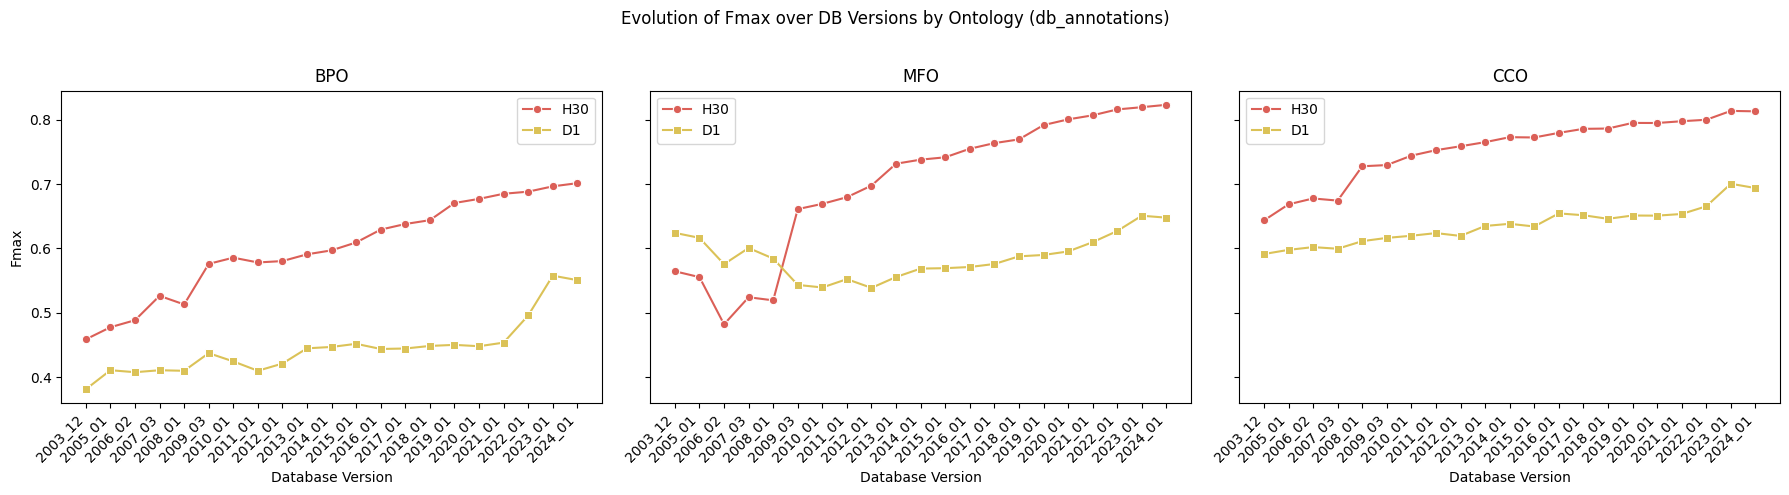

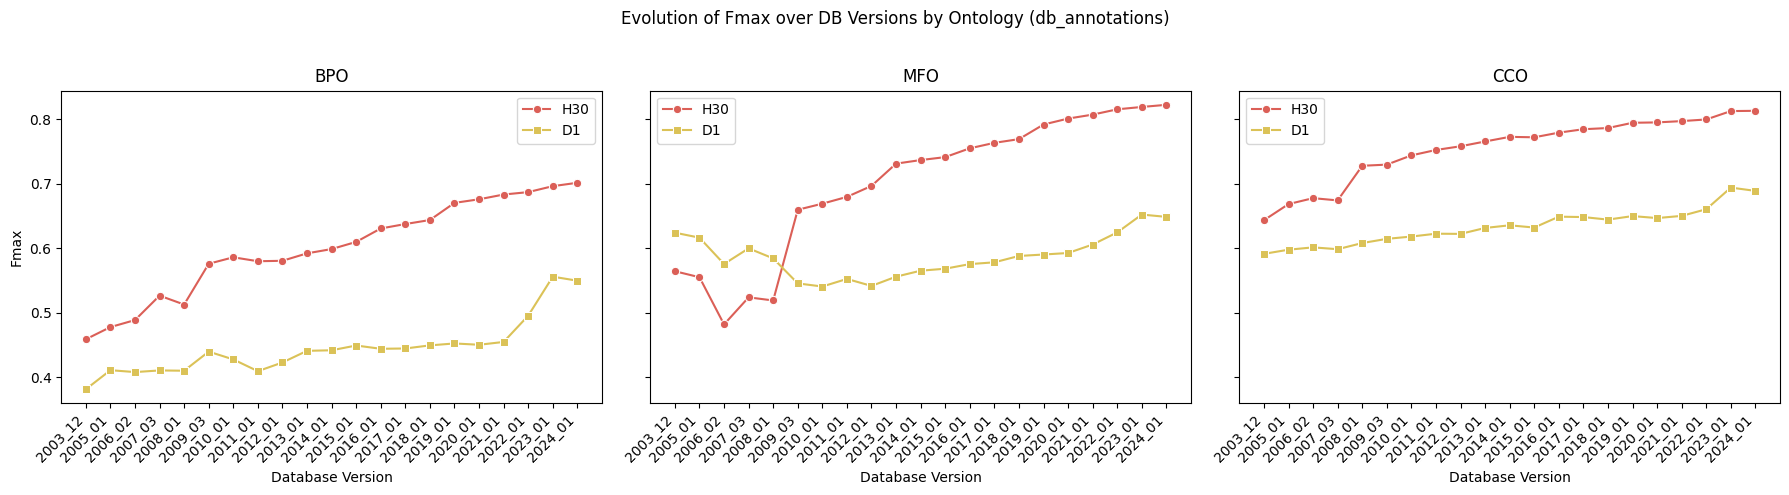

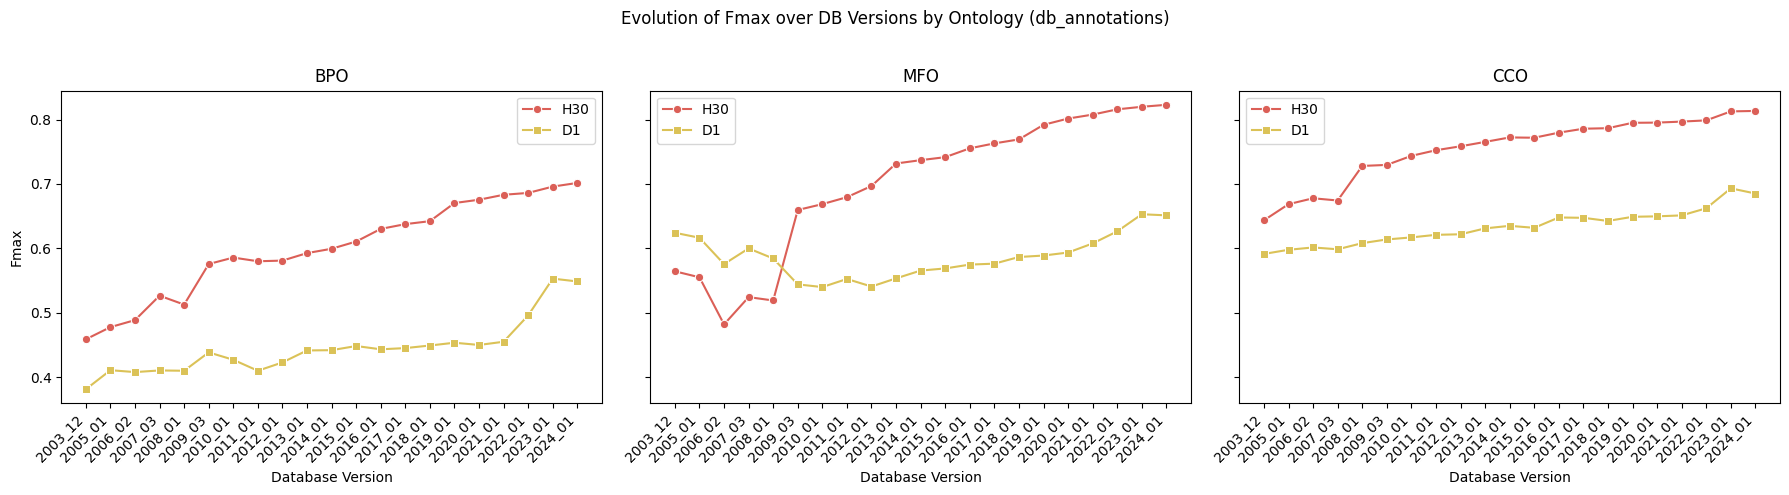

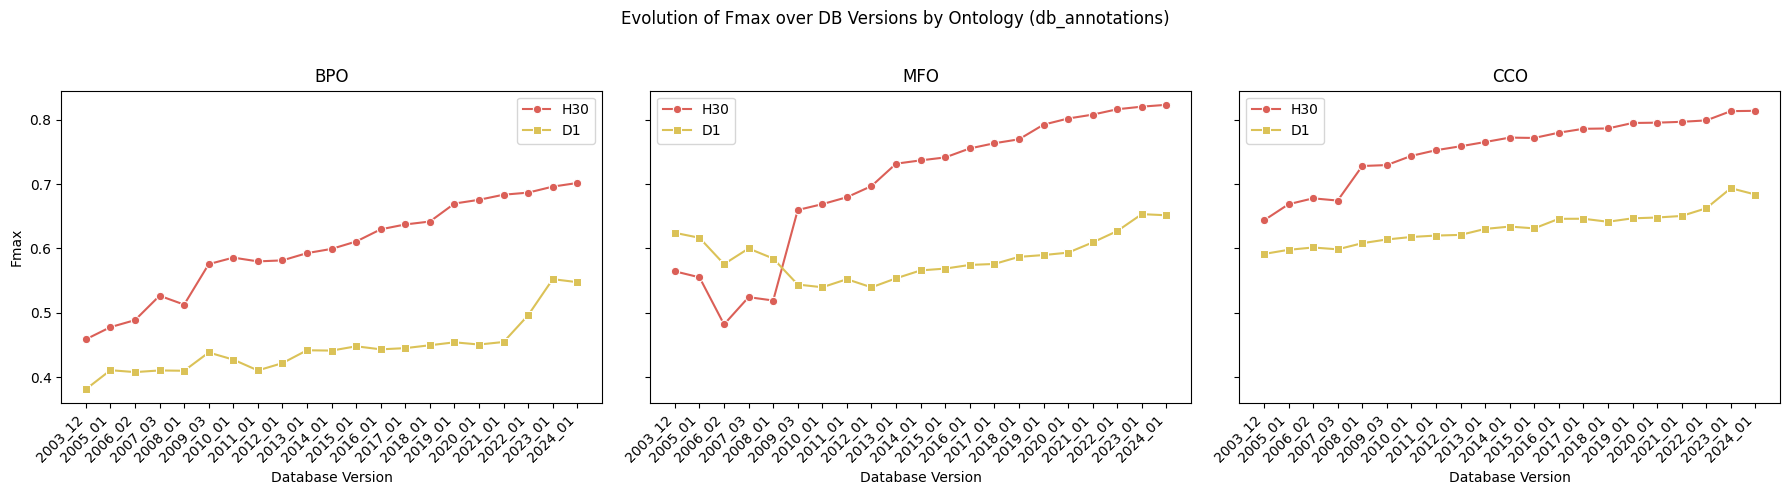

In [ ]:
plot_fmax_evolution_by_ontology(df_results, annotation_type='db_annotations', method='NaiveBaseline')
for k in [1, 3, 5, 10, 15, 20]:
    plot_fmax_evolution_by_ontology(df_results, annotation_type='db_annotations', method='BlastKNN', k=k)
plot_fmax_evolution_by_ontology(df_results, annotation_type='db_annotations', method='AlignmentScore')

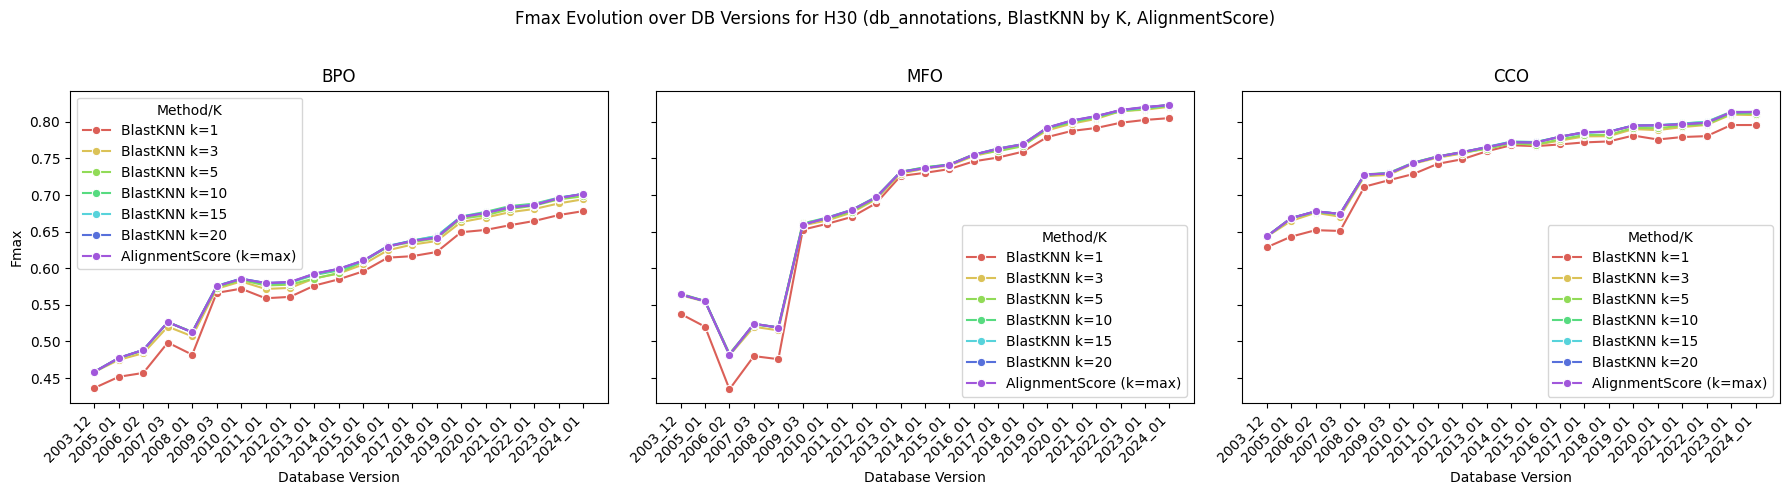

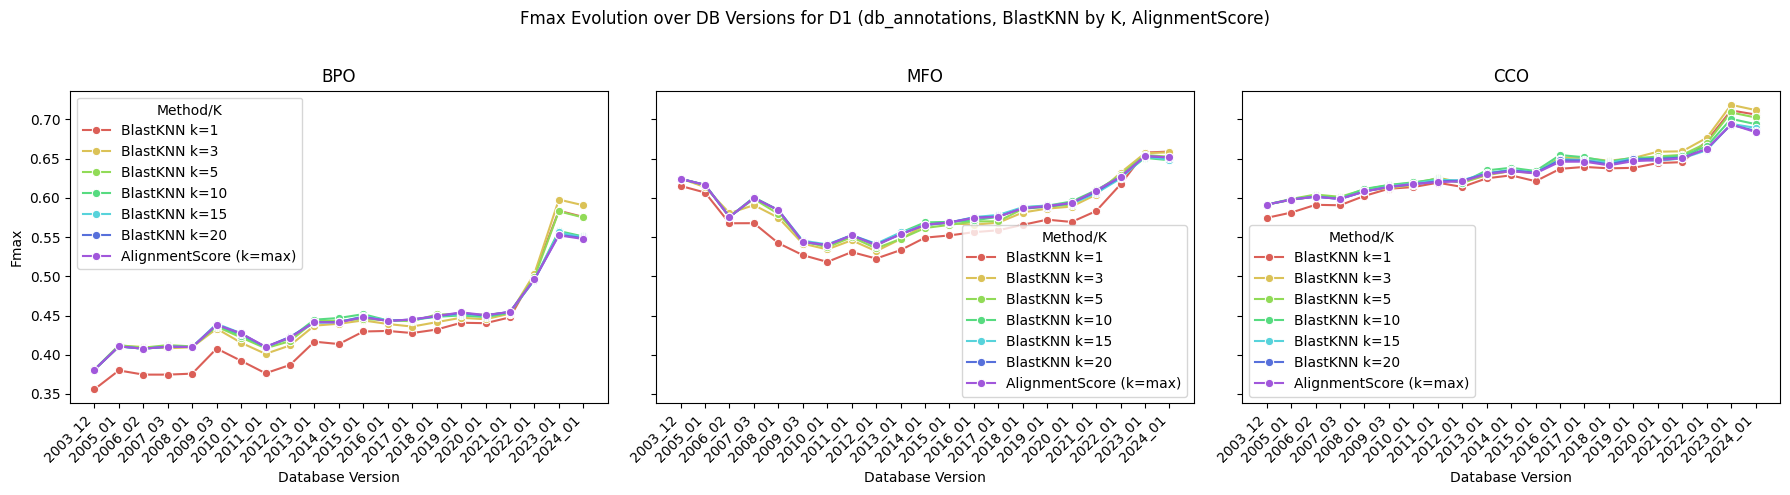

In [ ]:
plot_fmax_evolution_by_dataset_and_k(df_results, dataset='H30', annotation_type='db_annotations')
plot_fmax_evolution_by_dataset_and_k(df_results, dataset='D1', annotation_type='db_annotations')

## Modify and Use make_comparison_plots for Multiple DB Versions

Adapt the `make_comparison_plots` function to accept a list of results (one per db version) and plot PR curves (and other metrics) with a separate curve for each db version on the same axes.

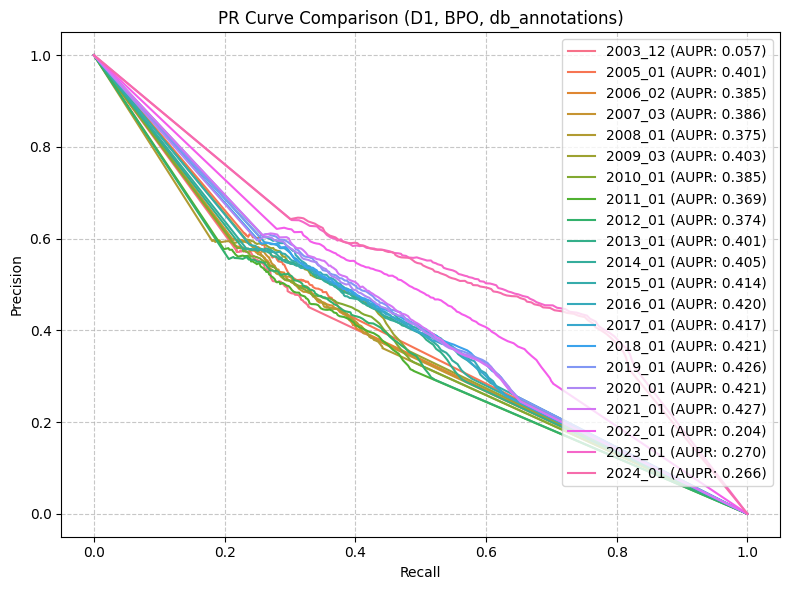

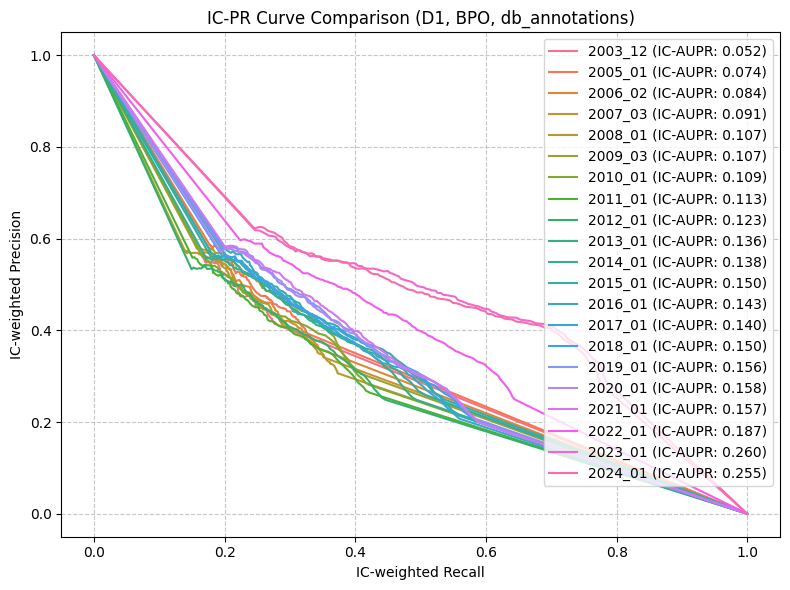

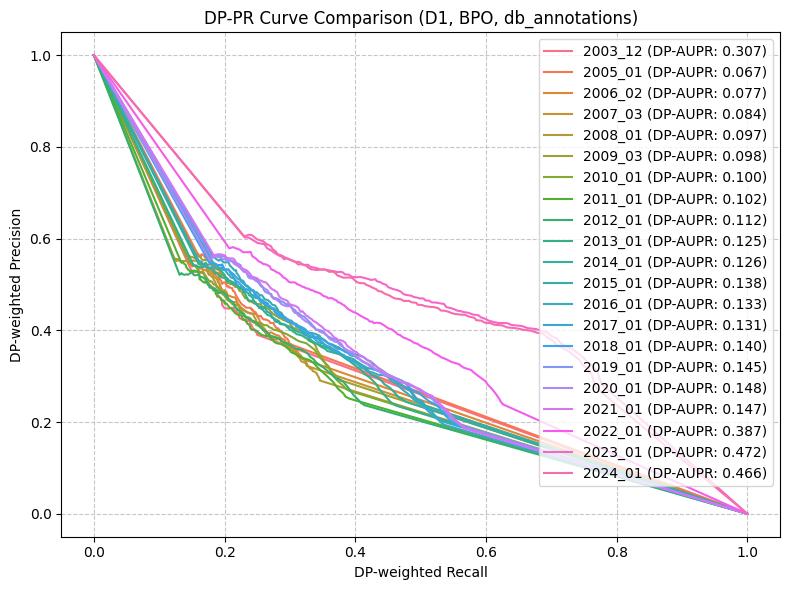

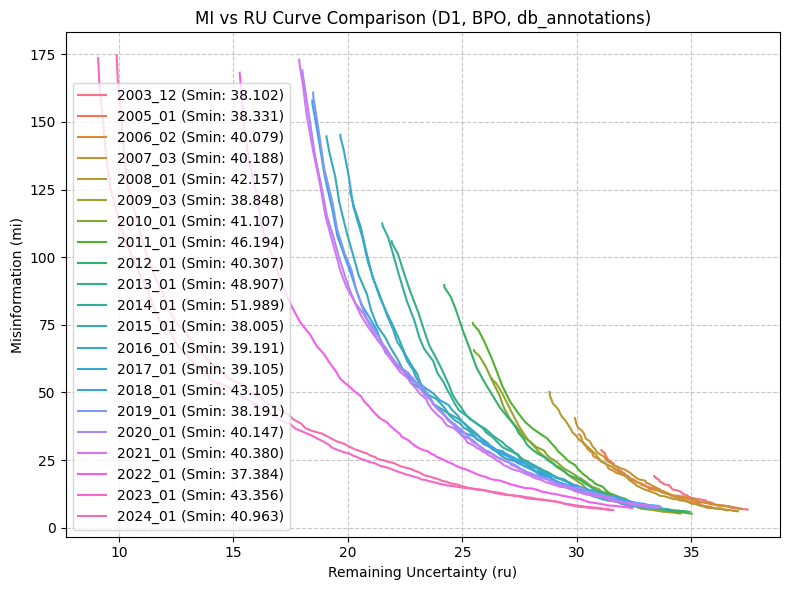

In [81]:
def add_pr_endpoints_to_df(df, recall_key, precision_key):
    """
    Add interpolation PR endpoints (0,1) and (1,0) to recall and precision arrays in the DataFrame.
    Modifies the DataFrame in place.
    """
    for idx, row in df.iterrows():
        rec = np.array(row.get(recall_key, []))
        prec = np.array(row.get(precision_key, []))
        if rec.size == 0 or prec.size == 0:
            continue
        changed = False
        if rec[0] > 0:
            rec = np.concatenate(([0], rec))
            prec = np.concatenate(([1], prec))
            changed = True
        if rec[-1] < 1:
            rec = np.concatenate((rec, [1.0]))
            prec = np.concatenate((prec, [0.0]))
            changed = True
        if changed:
            df.at[idx, recall_key] = rec
            df.at[idx, precision_key] = prec

def make_multi_db_comparison_plots_from_df(
    df, 
    ontology='BPO', 
    dataset='H30', 
    annotation_type='2024_annotations', 
    method='AlignmentScore', 
    k=None, 
    curve_type='pr'
):
    """
    Plot PR, IC-PR, DP-PR, and MI-vs-RU curves for multiple db_versions on the same axes,
    using the pandas DataFrame as input. Only plot the line, not the individual points.
    """
    # Filter dataframe for the requested subset
    subdf = df[
        (df['annotation_type'] == annotation_type) &
        (df['dataset'] == dataset) &
        (df['ontology'] == ontology) &
        (df['method'] == method)
    ]
    if k is not None and 'k' in subdf.columns:
        subdf = subdf[subdf['k'] == k]
    if subdf.empty:
        print("No data for the selected parameters.")
        return
    
    for recall_key, precision_key in [
    ('recalls', 'precisions'),
    ('dprecalls', 'dpprecisions'),
    ('icrecalls', 'icprecisions')
    ]:
    # Add pr endpoints to the DataFrame
        add_pr_endpoints_to_df(subdf, recall_key, precision_key)

    # Sort db_versions for consistent coloring
    db_versions = sorted(subdf['db_version'].unique())
    color_palette = sns.color_palette("husl", len(db_versions))
    plt.figure(figsize=(8, 6))

    for i, db_version in enumerate(db_versions):
        row = subdf[subdf['db_version'] == db_version]
        if row.empty:
            continue
        res = row.iloc[0]
        try:
            if curve_type == 'pr':
                x, y = res['recalls'], res['precisions']
                label = f"{db_version} (AUPR: {res.get('result_aupr', np.nan):.3f})"
                plt.plot(x, y, color=color_palette[i], label=label)
            elif curve_type == 'icpr':
                x, y = res['icrecalls'], res['icprecisions']
                label = f"{db_version} (IC-AUPR: {res.get('result_icaupr', np.nan):.3f})"
                plt.plot(x, y, color=color_palette[i], label=label)
            elif curve_type == 'dppr':
                x, y = res['dprecalls'], res['dpprecisions']
                label = f"{db_version} (DP-AUPR: {res.get('result_dpaupr', np.nan):.3f})"
                plt.plot(x, y, color=color_palette[i], label=label)
            elif curve_type == 'mi_ru':
                x, y = res['ru_values'], res['mi_values']
                label = f"{db_version} (Smin: {res.get('result_smin', np.nan):.3f})"
                plt.plot(x, y, color=color_palette[i], label=label)
        except Exception as e:
            print(f"Failed to plot {db_version}: {e}")

    if curve_type == 'pr':
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'PR Curve Comparison ({dataset}, {ontology}, {annotation_type})')
    elif curve_type == 'icpr':
        plt.xlabel('IC-weighted Recall')
        plt.ylabel('IC-weighted Precision')
        plt.title(f'IC-PR Curve Comparison ({dataset}, {ontology}, {annotation_type})')
    elif curve_type == 'dppr':
        plt.xlabel('DP-weighted Recall')
        plt.ylabel('DP-weighted Precision')
        plt.title(f'DP-PR Curve Comparison ({dataset}, {ontology}, {annotation_type})')
    elif curve_type == 'mi_ru':
        plt.xlabel('Remaining Uncertainty (ru)')
        plt.ylabel('Misinformation (mi)')
        plt.title(f'MI vs RU Curve Comparison ({dataset}, {ontology}, {annotation_type})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage:
make_multi_db_comparison_plots_from_df(df_results, ontology='BPO', dataset='D1', annotation_type='db_annotations', method='AlignmentScore', curve_type='pr')
make_multi_db_comparison_plots_from_df(df_results, ontology='BPO', dataset='D1', annotation_type='db_annotations', method='AlignmentScore', curve_type='icpr')
make_multi_db_comparison_plots_from_df(df_results, ontology='BPO', dataset='D1', annotation_type='db_annotations', method='AlignmentScore', curve_type='dppr')
make_multi_db_comparison_plots_from_df(df_results, ontology='BPO', dataset='D1', annotation_type='db_annotations', method='AlignmentScore', curve_type='mi_ru')

## Plot Evolution of Fmax Over Database Versions (db_annotations)

For folders under `db_annotations`, plot Fmax as a function of db version, with separate curves for H30 and D1. Use matplotlib or seaborn for line plots.

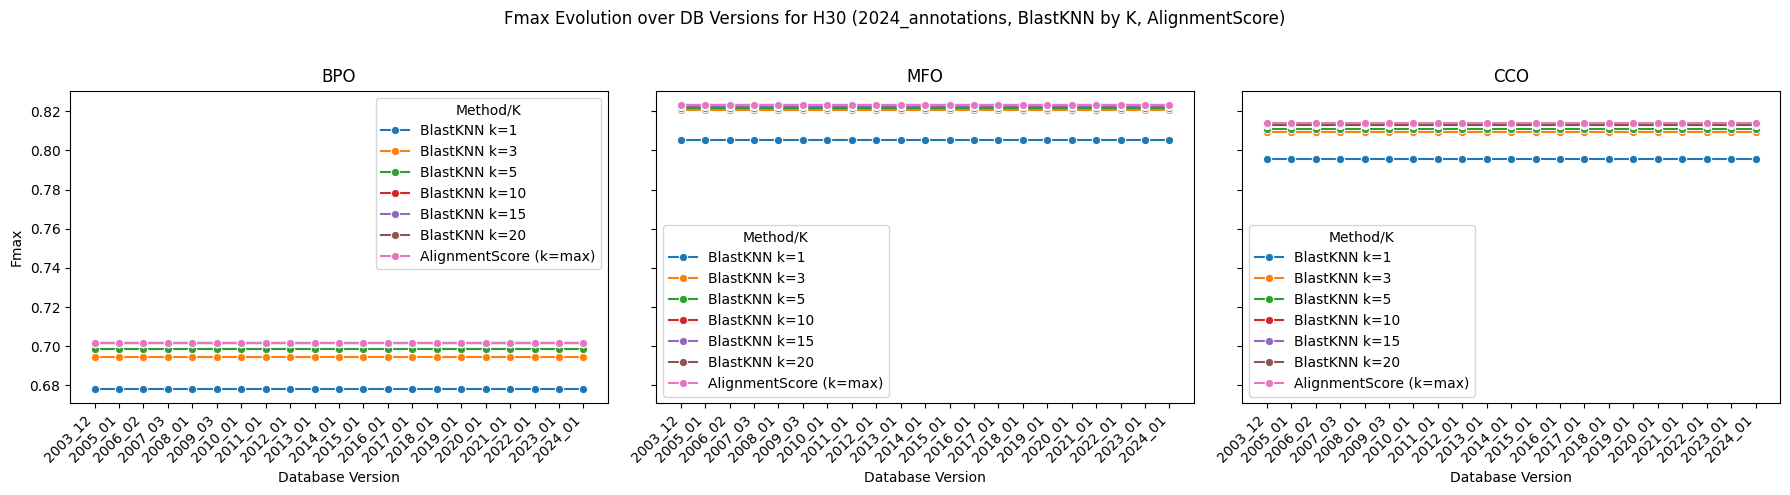

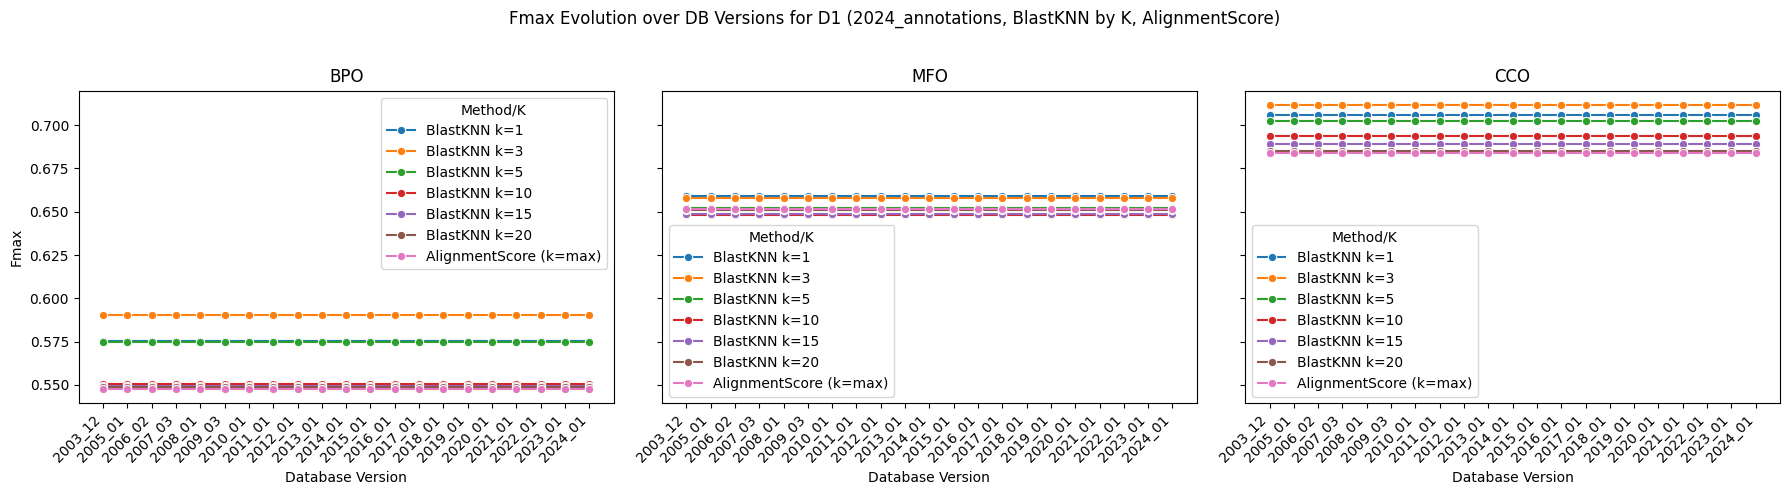

In [9]:
plot_fmax_evolution_by_dataset_and_k(df_results, dataset='H30', annotation_type='2024_annotations')
plot_fmax_evolution_by_dataset_and_k(df_results, dataset='D1', annotation_type='2024_annotations')

# Ground Truth and Predictions evolution over time

In [3]:
import pandas as pd
date = '2024_01'
subontology = 'BPO'
path = f"/home/atoffano/PFP_baselines/{date}/swissprot_{date}_{subontology}_annotations.tsv"
gt = pd.read_csv(path, sep='\t', names=['protein', 'go_terms'], header=0)
gt['go_terms'] = gt['go_terms'].apply(eval)
gt = gt[gt['protein'].isin(proteins)]
gt_set = set((row['protein'], term) for _, row in gt.iterrows() for term in row['go_terms'])


NameError: name 'proteins' is not defined

{'EGY3_ARATH', 'NFYB7_ARATH', 'LSM4_ARATH', 'PPR35_DROME', 'ERG5_CANAL', 'LSM8_ARATH', 'AGRE1_RAT', 'ASK17_ARATH', 'RETR2_MOUSE', 'ZN670_HUMAN', 'PP1R7_ARATH', 'BCL7C_MOUSE', 'GLTL_ECOLI', 'AT7L3_MOUSE', 'NU4LM_MOUSE', 'SCIN_HUMAN', 'ZDBF2_MOUSE', 'ATP6A_ARATH', 'IN80C_MOUSE', 'NUB1_MOUSE', 'RAB2B_MOUSE', 'SAMD1_MOUSE', 'SIPA_SALTY', 'PYR1_MOUSE', 'HAPR1_DANRE', 'INDH_ARATH', 'UBPA_DICDI', 'CYTSB_MOUSE', 'LSRB_ECOLI', 'OSGL1_HUMAN', 'SAU21_ARATH', 'FMT_HUMAN', 'RT33_MOUSE', 'AP5M1_MOUSE', 'S6OS1_HUMAN', 'TEX43_MOUSE', 'TCO2_MOUSE', 'TRM2A_HUMAN', 'CPNC_DICDI', 'PTPRV_MOUSE', 'CANB2_HUMAN', 'GCNA_HUMAN', 'UBP29_MOUSE', 'MS3L1_MOUSE', 'TM182_MOUSE', 'PFD6_ARATH', 'H2B1F_MOUSE', 'VTI13_ARATH', 'YHDZ_ECOLI', 'MGN2_MOUSE', 'FPGT_MOUSE', 'CBAR1_MOUSE', 'ZPR1_DROME', 'HECD1_HUMAN', 'RM09_MOUSE', 'BRDH_DROME', 'HICB_ECOLI', 'P66B_MOUSE', 'HS3SA_MOUSE', 'BARA2_DROME', 'MNS60_HUMAN', 'WDL4_ARATH', 'FCG3A_MOUSE', 'CV_ARATH', 'RBX1B_ARATH', 'CIROP_XENLA', 'GACW_DICDI', 'JADE3_MOUSE', 'ABPB_ECOLI',

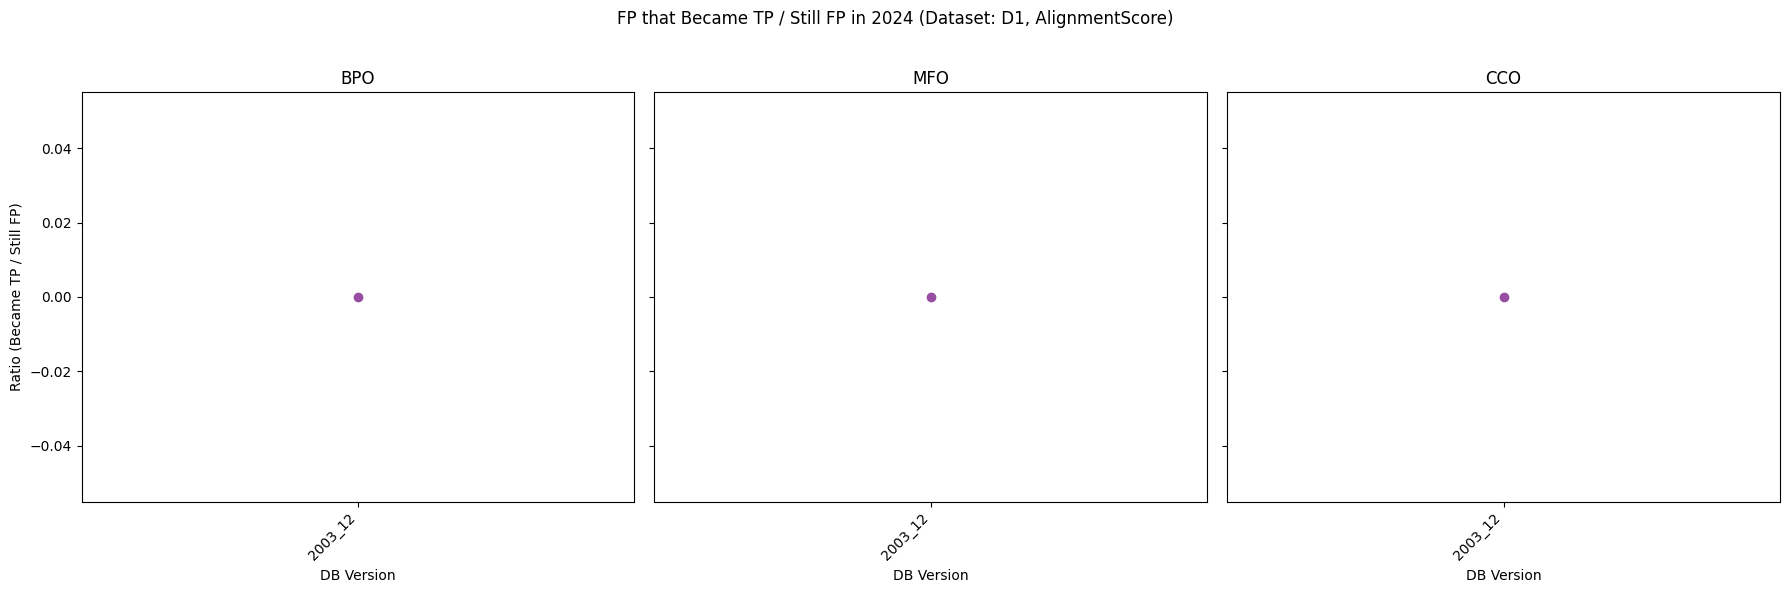

{'EGY3_ARATH', 'NFYB7_ARATH', 'LSM4_ARATH', 'PPR35_DROME', 'ERG5_CANAL', 'LSM8_ARATH', 'AGRE1_RAT', 'ASK17_ARATH', 'RETR2_MOUSE', 'ZN670_HUMAN', 'PP1R7_ARATH', 'BCL7C_MOUSE', 'GLTL_ECOLI', 'AT7L3_MOUSE', 'NU4LM_MOUSE', 'SCIN_HUMAN', 'ZDBF2_MOUSE', 'ATP6A_ARATH', 'IN80C_MOUSE', 'NUB1_MOUSE', 'RAB2B_MOUSE', 'SAMD1_MOUSE', 'SIPA_SALTY', 'PYR1_MOUSE', 'HAPR1_DANRE', 'INDH_ARATH', 'UBPA_DICDI', 'CYTSB_MOUSE', 'LSRB_ECOLI', 'OSGL1_HUMAN', 'SAU21_ARATH', 'FMT_HUMAN', 'RT33_MOUSE', 'AP5M1_MOUSE', 'S6OS1_HUMAN', 'TEX43_MOUSE', 'TCO2_MOUSE', 'TRM2A_HUMAN', 'CPNC_DICDI', 'PTPRV_MOUSE', 'CANB2_HUMAN', 'GCNA_HUMAN', 'UBP29_MOUSE', 'MS3L1_MOUSE', 'TM182_MOUSE', 'PFD6_ARATH', 'H2B1F_MOUSE', 'VTI13_ARATH', 'YHDZ_ECOLI', 'MGN2_MOUSE', 'FPGT_MOUSE', 'CBAR1_MOUSE', 'ZPR1_DROME', 'HECD1_HUMAN', 'RM09_MOUSE', 'BRDH_DROME', 'HICB_ECOLI', 'P66B_MOUSE', 'HS3SA_MOUSE', 'BARA2_DROME', 'MNS60_HUMAN', 'WDL4_ARATH', 'FCG3A_MOUSE', 'CV_ARATH', 'RBX1B_ARATH', 'CIROP_XENLA', 'GACW_DICDI', 'JADE3_MOUSE', 'ABPB_ECOLI',

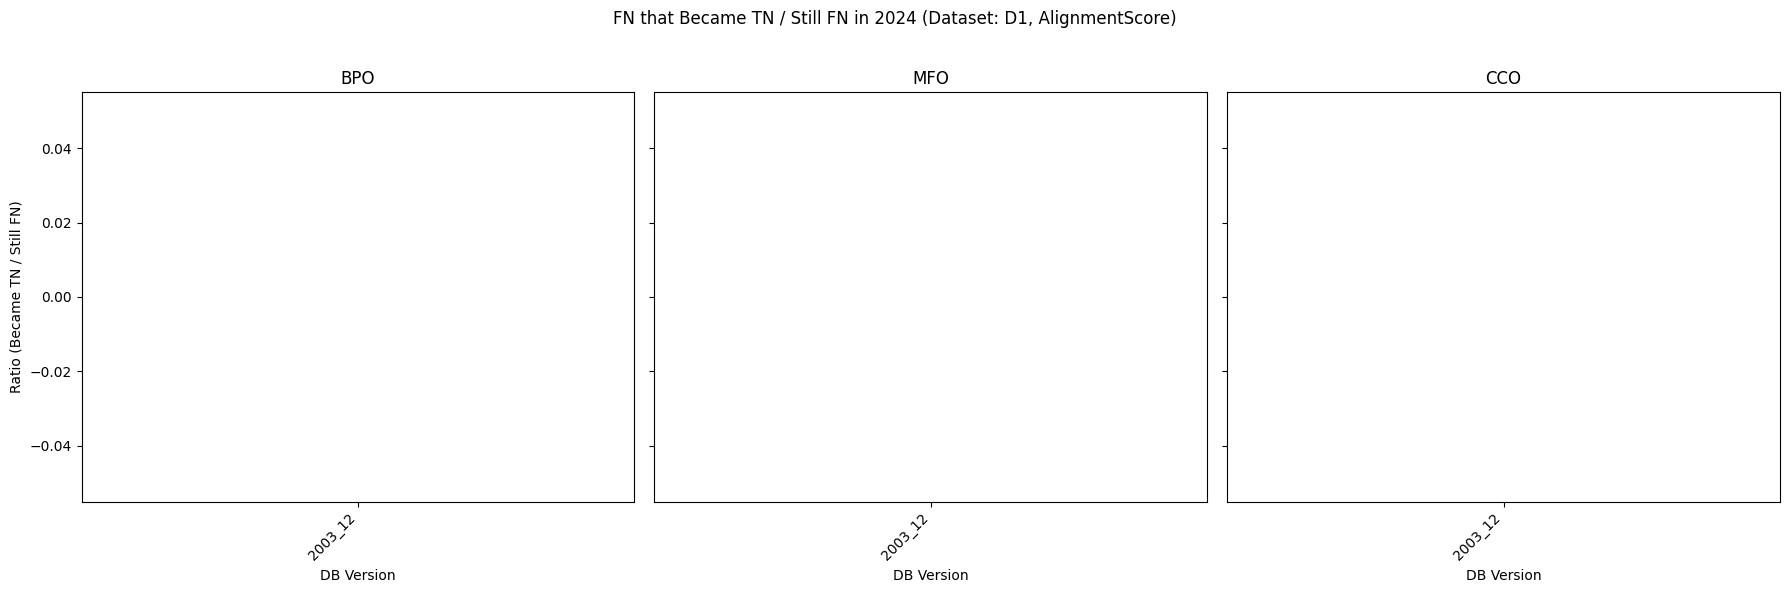

{'CENPO_KLULA', 'DCK1_YEAST', 'COG5_DICDI', 'SPO7_SCHPO', 'DOGL4_ARATH', 'PEX12_ARATH', 'HISZ_THEMA', 'NK_THEAC', 'RSC3_YEAST', 'AKECT_STUS1', 'EXO5_SCHPO', 'IBMP_CYLCV', 'SPC98_YEAST', 'NPR2_YEAST', 'YON1_SCHPO', 'CBIQ_SALTY', 'HAP2_CHLRE', 'LYSDH_GEOSE', 'TSRM_STRLU', 'BTB2_SCHPO', 'SYG1_CAEEL', 'MNT4_CANAL', 'RM20_SCHPO', 'SRP68_YEAST', 'YDDG_ANCN5', 'CHEF1_HALS3', 'DUT_MUHVS', 'ORA4_DANRE', 'GL43A_DROME', 'YL823_MIMIV', 'TTS1_SCHPO', 'YK58_YEAST', 'GIT1_SCHPO', 'PLBL_DROME', 'PAT1_YEAST', 'CUP15_CAEEL', 'GEF3_SCHPO', 'COTI_BACSU', 'NRDE2_CAEEL', 'TSTA_DICDI', 'NOP53_CAEEL', 'FYV7_YARLI', 'CDC16_DICDI', 'NU107_SCHPO', 'MUP1_YEAST', 'MUG51_SCHPO', 'RDRP_WCCVB', 'PEHX_DICCH', 'SRB16_CAEEL', 'URHG2_BACSU', 'ELP5_ARATH', 'RMTC_PROMI', 'REC11_SCHPO', 'PHAE_RHIME', 'YFCP_ECOLI', 'SEOC_ARATH', 'FSH1_YEAST', 'ABIA_DICDI', 'ELP1_ARATH', 'CGLR2_CRAVI', 'POPI_SCHPO', 'TPR_DROME', 'YFMO_BACSU', 'COG2_ARATH', 'RM11_YEAST', 'SYFB_UREPA', 'EDE1_YEAST', 'NICA_ARATH', 'RDRP_LDCPR', 'PEX25_YEAST', 'P

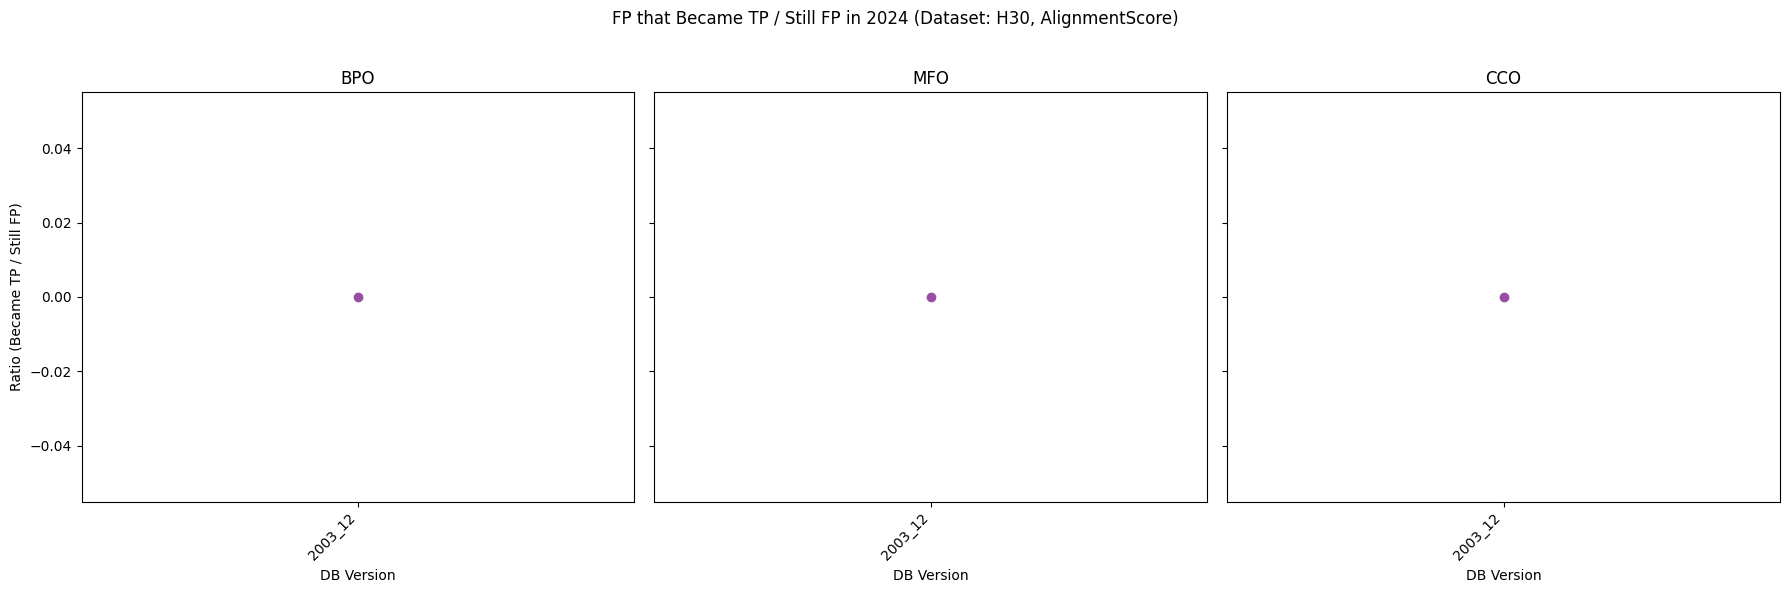

{'CENPO_KLULA', 'DCK1_YEAST', 'COG5_DICDI', 'SPO7_SCHPO', 'DOGL4_ARATH', 'PEX12_ARATH', 'HISZ_THEMA', 'NK_THEAC', 'RSC3_YEAST', 'AKECT_STUS1', 'EXO5_SCHPO', 'IBMP_CYLCV', 'SPC98_YEAST', 'NPR2_YEAST', 'YON1_SCHPO', 'CBIQ_SALTY', 'HAP2_CHLRE', 'LYSDH_GEOSE', 'TSRM_STRLU', 'BTB2_SCHPO', 'SYG1_CAEEL', 'MNT4_CANAL', 'RM20_SCHPO', 'SRP68_YEAST', 'YDDG_ANCN5', 'CHEF1_HALS3', 'DUT_MUHVS', 'ORA4_DANRE', 'GL43A_DROME', 'YL823_MIMIV', 'TTS1_SCHPO', 'YK58_YEAST', 'GIT1_SCHPO', 'PLBL_DROME', 'PAT1_YEAST', 'CUP15_CAEEL', 'GEF3_SCHPO', 'COTI_BACSU', 'NRDE2_CAEEL', 'TSTA_DICDI', 'NOP53_CAEEL', 'FYV7_YARLI', 'CDC16_DICDI', 'NU107_SCHPO', 'MUP1_YEAST', 'MUG51_SCHPO', 'RDRP_WCCVB', 'PEHX_DICCH', 'SRB16_CAEEL', 'URHG2_BACSU', 'ELP5_ARATH', 'RMTC_PROMI', 'REC11_SCHPO', 'PHAE_RHIME', 'YFCP_ECOLI', 'SEOC_ARATH', 'FSH1_YEAST', 'ABIA_DICDI', 'ELP1_ARATH', 'CGLR2_CRAVI', 'POPI_SCHPO', 'TPR_DROME', 'YFMO_BACSU', 'COG2_ARATH', 'RM11_YEAST', 'SYFB_UREPA', 'EDE1_YEAST', 'NICA_ARATH', 'RDRP_LDCPR', 'PEX25_YEAST', 'P

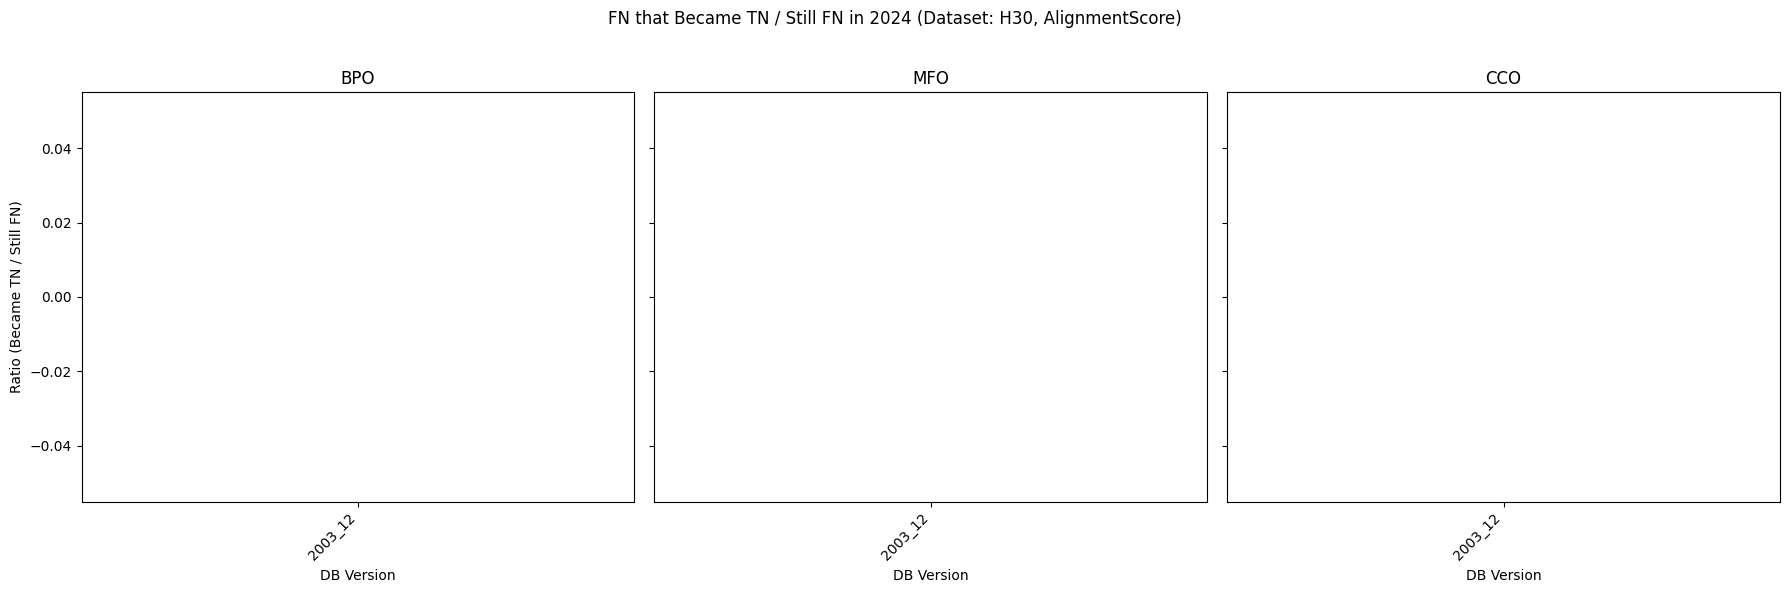

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# dates = [
#     '2024_01', '2023_01', '2022_01', '2021_01', '2020_01', '2019_01', '2018_01',
#     '2017_01', '2016_01', '2015_01', '2014_01', '2013_01', '2012_01', '2011_01',
#     '2010_01', '2009_03', '2008_01', '2007_03', '2006_02', '2005_01', '2003_12'
# ]
dates = [
    '2003_12'
]

subontologies = ['BPO', 'MFO', 'CCO']

# --- Caching loaded data to avoid redundant disk reads ---
_gt_cache, _pred_cache, _t_cache = {}, {}, {}

def load_proteins_of_interest(dataset, subontology):
    path = f"/home/atoffano/PFP_baselines/{dataset}_test_annotations/{dataset}_{subontology}_test.tsv"
    df = pd.read_csv(path, sep='\t')
    return set(df['target_ID'].unique())

def load_gt_db(date, subontology, proteins):
    key = (date, subontology, tuple(sorted(proteins)))
    if key in _gt_cache:
        return _gt_cache[key]
    path = f"/home/atoffano/PFP_baselines/{date}/swissprot_{date}_{subontology}_annotations.tsv"
    gt = pd.read_csv(path, sep='\t', names=['protein', 'go_terms'], header=0)
    gt['go_terms'] = gt['go_terms'].apply(eval)
    gt = gt[gt['protein'].isin(proteins)]
    gt_set = set((row['protein'], term) for _, row in gt.iterrows() for term in row['go_terms'])
    _gt_cache[key] = gt_set
    return gt_set

def load_predictions(date, subontology, dataset):
    key = (date, subontology, dataset)
    if key in _pred_cache:
        return _pred_cache[key]
    path = f"/home/atoffano/PFP_baselines/{date}/baselines_{dataset}_{date}_{subontology}/predictions/AlignmentScore/predictions.tsv"
    if not os.path.exists(path):
        _pred_cache[key] = None
        return None
    df = pd.read_csv(path, sep='\t', names=['protein', 'go_term', 'score'], header=0)
    _pred_cache[key] = df
    return df

def load_result_t(date, subontology, dataset):
    key = (date, subontology, dataset)
    if key in _t_cache:
        return _t_cache[key]
    path = f"/home/atoffano/PFP_baselines/{date}/baselines_{dataset}_{date}_{subontology}/predictions/AlignmentScore/eval_beprof_evaluation_results_detailed.pkl"
    if not os.path.exists(path):
        _t_cache[key] = None
        return None
    with open(path, 'rb') as f:
        res = pickle.load(f)
    _t_cache[key] = res['result_t']
    return res['result_t']

def plot_fp_fn_ratios(dates, subontologies, dataset):
    for metric, title, color, numer, denom, ylabel in [
        ('FP', 'FP that Became TP / Still FP', '#984ea3', lambda fp, gt2024: len(fp & gt2024), lambda fp, gt2024: len(fp - gt2024), 'Ratio (Became TP / Still FP)'),
        ('FN', 'FN that Became TN / Still FN', '#ff7f00', lambda fn, gt2024: len(fn - gt2024), lambda fn, gt2024: len(fn & gt2024), 'Ratio (Became TN / Still FN)')
    ]:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        for i, sub in enumerate(subontologies):
            prots = load_proteins_of_interest(dataset, sub)
            gt2024 = load_gt_db('2024_01', sub, prots)
            print(gt2024)
            ratios, valid_dates = [], []
            for date in dates:
                pred = load_predictions(date, sub, dataset)
                t = load_result_t(date, sub, dataset)
                if pred is None or t is None:
                    ratios.append(np.nan)
                    continue
                gt = load_gt_db(date, sub, prots)
                pred_above = set(pred[pred['score'] >= t][['protein', 'go_term']].itertuples(index=False, name=None))
                print(pred_above)
                if metric == 'FP':
                    fp = pred_above - gt
                    print(len(fp))
                    became_tp = fp & gt2024
                    still_fp = fp - gt2024
                    print(len(became_tp), (still_fp))
                    ratio = len(became_tp) / len(still_fp) if still_fp else np.nan
                else:
                    fn = gt - pred_above
                    became_tn = fn - gt2024
                    still_fn = fn & gt2024
                    ratio = len(became_tn) / len(still_fn) if still_fn else np.nan
                ratios.append(ratio)
                valid_dates.append(date)
            print(ratios)
            print(valid_dates)
            ax = axes[i]
            ax.plot(valid_dates, ratios, marker='o', color=color)
            ax.set_title(sub)
            ax.set_xlabel('DB Version')
            if i == 0: ax.set_ylabel(ylabel)
            ax.tick_params(axis='x', rotation=45)
            for label in ax.get_xticklabels(): label.set_ha('right')
        plt.suptitle(f'{title} in 2024 (Dataset: {dataset}, AlignmentScore)')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Example usage:
plot_fp_fn_ratios(dates, subontologies, dataset='D1')
plot_fp_fn_ratios(dates, subontologies, dataset='H30')

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dates = [
    '2024_01', '2023_01', '2022_01', '2021_01', '2020_01', '2019_01', '2018_01',
    '2017_01', '2016_01', '2015_01', '2014_01', '2013_01', '2012_01', '2011_01',
    '2010_01', '2009_03', '2008_01', '2007_03', '2006_02', '2005_01', '2003_12'
]
subontologies = ['BPO', 'MFO', 'CCO']

def load_gt_db(date, subontology):
    gt_path = f"/home/atoffano/PFP_baselines/{date}/swissprot_{date}_{subontology}_annotations.tsv"
    gt_db = pd.read_csv(gt_path, sep='\t', names=['protein', 'go_terms'], header=0)
    if isinstance(gt_db['go_terms'].iloc[0], str):
        gt_db['go_terms'] = gt_db['go_terms'].apply(eval)
    gt_db_set = set((row['protein'], term) for _, row in gt_db.iterrows() for term in row['go_terms'])
    return gt_db_set

def load_predictions(date, subontology):
    pred_path = f"/home/atoffano/PFP_baselines/{date}/baselines_H30_{date}_{subontology}/predictions/AlignmentScore/predictions.tsv"
    if not os.path.exists(pred_path):
        return None
    pred_df = pd.read_csv(pred_path, sep='\t', names=['protein', 'go_term', 'score'], header=0)
    return pred_df

def load_result_t(date, subontology):
    eval_path = f"/home/atoffano/PFP_baselines/{date}/baselines_H30_{date}_{subontology}/predictions/AlignmentScore/eval_beprof_evaluation_results_detailed.pkl"
    if not os.path.exists(eval_path):
        return None
    with open(eval_path, 'rb') as f:
        res = pickle.load(f)
    return res['result_t']

# Plot 1: Fate of False Positives (Above threshold)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, subontology in enumerate(subontologies):
    gt_2024_set = load_gt_db('2024_01', subontology)
    still_fp, became_tp = [], []
    valid_dates = []
    for date in dates:
        pred_df = load_predictions(date, subontology)
        t = load_result_t(date, subontology)
        if pred_df is None or t is None:
            still_fp.append(np.nan)
            became_tp.append(np.nan)
            continue
        gt_db_set = load_gt_db(date, subontology)
        pred_above = set(pred_df[pred_df['score'] >= t][['protein', 'go_term']].itertuples(index=False, name=None))
        # Above threshold: FP in db GT
        fp_db = pred_above - gt_db_set
        # Still FP in 2024
        still_fp.append(len(fp_db - gt_2024_set))
        # Became TP in 2024 (was FP in db GT, but is TP in 2024 GT)
        became_tp.append(len(fp_db & gt_2024_set))
        valid_dates.append(date)
    ax = axes[i]
    ax.plot(valid_dates, became_tp, label='Became True Positive', marker='o', color='#4daf4a')
    ax.plot(valid_dates, still_fp, label='Still False Positive', marker='o', color='#e41a1c')
    ax.set_title(subontology)
    ax.set_xlabel('DB Version')
    if i == 0:
        ax.set_ylabel('Count')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')
plt.suptitle('Fate of False Positives Across DB Versions (H30, AlignmentScore, result_t threshold)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot 2: Fate of False Negatives (Below threshold)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, subontology in enumerate(subontologies):
    gt_2024_set = load_gt_db('2024_01', subontology)
    still_fn, became_tn = [], []
    valid_dates = []
    for date in dates:
        pred_df = load_predictions(date, subontology)
        t = load_result_t(date, subontology)
        if pred_df is None or t is None:
            still_fn.append(np.nan)
            became_tn.append(np.nan)
            continue
        gt_db_set = load_gt_db(date, subontology)
        pred_above = set(pred_df[pred_df['score'] >= t][['protein', 'go_term']].itertuples(index=False, name=None))
        pred_below = set(pred_df[pred_df['score'] < t][['protein', 'go_term']].itertuples(index=False, name=None))
        # False Negatives in db GT: in GT but not predicted above threshold
        fn_db = gt_db_set - pred_above
        # Still FN in 2024
        still_fn.append(len(fn_db & gt_2024_set))
        # Became TN in 2024 (was FN in db GT, but not in 2024 GT)
        became_tn.append(len(fn_db - gt_2024_set))
        valid_dates.append(date)
    ax = axes[i]
    ax.plot(valid_dates, became_tn, label='Became True Negative', marker='o', color='#377eb8')
    ax.plot(valid_dates, still_fn, label='Still False Negative', marker='o', color='#ff7f00')
    ax.set_title(subontology)
    ax.set_xlabel('DB Version')
    if i == 0:
        ax.set_ylabel('Count')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')
plt.suptitle('Fate of False Negatives Across DB Versions (H30, AlignmentScore, result_t threshold)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()